In [1]:
allow_train = True
freeze_encoder = False
EPOCHS = 10
BATCH_SIZE = 32
shrink_size = 20

lr = 0.1
weight_deacay = 1e-4
T_max = 15
eta_min = 0.001

In [2]:
import torch
from torch import nn
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR

from going_modular import engine_post_train, utils
from going_modular import custom_data_setup_post_train
import helper_functions

c:\Users\Amiroodi\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
no_transforms = helper_functions.get_augmentation_no_transforms()

In [5]:
train_val_dataloader, class_names = custom_data_setup_post_train.create_train_val_dataloader(transform=no_transforms, batch_size=BATCH_SIZE, device=device, shrink_size=shrink_size)

test_dataloader, class_names = custom_data_setup_post_train.create_test_dataloader(transform=no_transforms, batch_size=BATCH_SIZE, device=device, shrink_size=shrink_size)

exp_dataloader, class_names = custom_data_setup_post_train.create_train_dataloader(transform=no_transforms, batch_size=BATCH_SIZE, device=device, shrink_size=shrink_size)

In [6]:
class OneHeadCNN(nn.Module):
    def __init__(self):
        super(OneHeadCNN, self).__init__()

        self.final_head = nn.Sequential(
            # nn.Linear(3, 10),
            # nn.ReLU(),
            # nn.Linear(10, 5),
            # nn.ReLU(),
            # nn.Linear(5, 3),
            # nn.ReLU(),
            nn.Linear(3, 1)
        )
        
    def forward(self, x):
        return self.final_head(x)

model = OneHeadCNN().to(device)

In [7]:
# Initialize all weights to 1/3
def init_weights_custom(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight, 1/3)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

model.apply(init_weights_custom)

OneHeadCNN(
  (final_head): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
  )
)

In [8]:
# Define loss and optimizer

loss_fn = nn.MSELoss().to(device)

optimizer = torch.optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_deacay)
scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

In [9]:
folds_train_results = {
    'loss_train': []
}
folds_val_results = {
    'loss_val': []
}
if allow_train:
    # Set the random seeds
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Setup training and save the results
    for fold in train_val_dataloader:
        train_results, val_results = engine_post_train.train(model=model,
                            train_dataloader=fold['train_dataloader'],
                            val_dataloader=fold['val_dataloader'],
                            optimizer=optimizer,
                            scheduler=scheduler,
                            loss_fn=loss_fn,
                            epochs=EPOCHS,
                            device=device)
        
        folds_train_results['loss_train'].extend(train_results['loss_train'])

        folds_val_results['loss_val'].extend(val_results['loss_val'])

    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

    utils.save_model(model=model, target_dir='models', model_name='post_train_model.pth')
else:
    model.load_state_dict(torch.load('models/post_train_model.pth', weights_only=True, map_location=device))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
loss_train: 7.0833 | loss_val: 1.9178 | acc_val: 0.0000

Epoch: 1
loss_train: 6.5769 | loss_val: 1.5361 | acc_val: 0.0000

Epoch: 2
loss_train: 6.1612 | loss_val: 1.2422 | acc_val: 0.0000

Epoch: 3
loss_train: 5.8214 | loss_val: 1.0259 | acc_val: 0.2500

Epoch: 4
loss_train: 5.5382 | loss_val: 0.8713 | acc_val: 0.5000

Epoch: 5
loss_train: 5.2953 | loss_val: 0.8679 | acc_val: 0.5000

Epoch: 6
loss_train: 5.2894 | loss_val: 0.8656 | acc_val: 0.5000

Epoch: 7
loss_train: 5.2820 | loss_val: 0.8643 | acc_val: 0.5000

Epoch: 8
loss_train: 5.2738 | loss_val: 0.8639 | acc_val: 0.5000

Epoch: 9
loss_train: 5.2658 | loss_val: 0.8640 | acc_val: 0.5000



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
loss_train: 4.0447 | loss_val: 5.7144 | acc_val: 0.2500

Epoch: 1
loss_train: 4.0400 | loss_val: 5.7110 | acc_val: 0.2500

Epoch: 2
loss_train: 4.0366 | loss_val: 5.7089 | acc_val: 0.2500

Epoch: 3
loss_train: 4.0343 | loss_val: 5.7079 | acc_val: 0.2500

Epoch: 4
loss_train: 4.0330 | loss_val: 5.7074 | acc_val: 0.2500

Epoch: 5
loss_train: 4.0325 | loss_val: 5.7072 | acc_val: 0.2500

Epoch: 6
loss_train: 4.0323 | loss_val: 5.7067 | acc_val: 0.2500

Epoch: 7
loss_train: 4.0317 | loss_val: 5.7056 | acc_val: 0.2500

Epoch: 8
loss_train: 4.0301 | loss_val: 5.7032 | acc_val: 0.2500

Epoch: 9
loss_train: 4.0269 | loss_val: 5.6991 | acc_val: 0.2500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
loss_train: 5.2159 | loss_val: 0.9162 | acc_val: 0.2500

Epoch: 1
loss_train: 5.2072 | loss_val: 0.9103 | acc_val: 0.2500

Epoch: 2
loss_train: 5.1951 | loss_val: 0.9034 | acc_val: 0.2500

Epoch: 3
loss_train: 5.1792 | loss_val: 0.8960 | acc_val: 0.2500

Epoch: 4
loss_train: 5.1593 | loss_val: 0.8884 | acc_val: 0.2500

Epoch: 5
loss_train: 5.1355 | loss_val: 0.8810 | acc_val: 0.2500

Epoch: 6
loss_train: 5.1079 | loss_val: 0.8742 | acc_val: 0.2500

Epoch: 7
loss_train: 5.0768 | loss_val: 0.8680 | acc_val: 0.2500

Epoch: 8
loss_train: 5.0426 | loss_val: 0.8626 | acc_val: 0.2500

Epoch: 9
loss_train: 5.0059 | loss_val: 0.8579 | acc_val: 0.2500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
loss_train: 3.8096 | loss_val: 5.4523 | acc_val: 0.0000

Epoch: 1
loss_train: 3.7779 | loss_val: 5.4165 | acc_val: 0.0000

Epoch: 2
loss_train: 3.7464 | loss_val: 5.3814 | acc_val: 0.0000

Epoch: 3
loss_train: 3.7156 | loss_val: 5.3474 | acc_val: 0.0000

Epoch: 4
loss_train: 3.6865 | loss_val: 5.3151 | acc_val: 0.0000

Epoch: 5
loss_train: 3.6593 | loss_val: 5.2849 | acc_val: 0.0000

Epoch: 6
loss_train: 3.6347 | loss_val: 5.2573 | acc_val: 0.0000

Epoch: 7
loss_train: 3.6130 | loss_val: 5.2328 | acc_val: 0.0000

Epoch: 8
loss_train: 3.5944 | loss_val: 5.2121 | acc_val: 0.0000

Epoch: 9
loss_train: 3.5791 | loss_val: 5.1952 | acc_val: 0.0000



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
loss_train: 2.9952 | loss_val: 7.4687 | acc_val: 0.2500

Epoch: 1
loss_train: 2.9860 | loss_val: 7.4621 | acc_val: 0.2500

Epoch: 2
loss_train: 2.9787 | loss_val: 7.4594 | acc_val: 0.2500

Epoch: 3
loss_train: 2.9737 | loss_val: 7.4586 | acc_val: 0.2500

Epoch: 4
loss_train: 2.9710 | loss_val: 7.4584 | acc_val: 0.2500

Epoch: 5
loss_train: 2.9699 | loss_val: 7.4585 | acc_val: 0.2500

Epoch: 6
loss_train: 2.9693 | loss_val: 7.4587 | acc_val: 0.2500

Epoch: 7
loss_train: 2.9680 | loss_val: 7.4596 | acc_val: 0.2500

Epoch: 8
loss_train: 2.9646 | loss_val: 7.4620 | acc_val: 0.2500

Epoch: 9
loss_train: 2.9576 | loss_val: 7.4673 | acc_val: 0.2500

[INFO] Total training time: 0.082 seconds
[INFO] Saving model to: models\post_train_model.pth


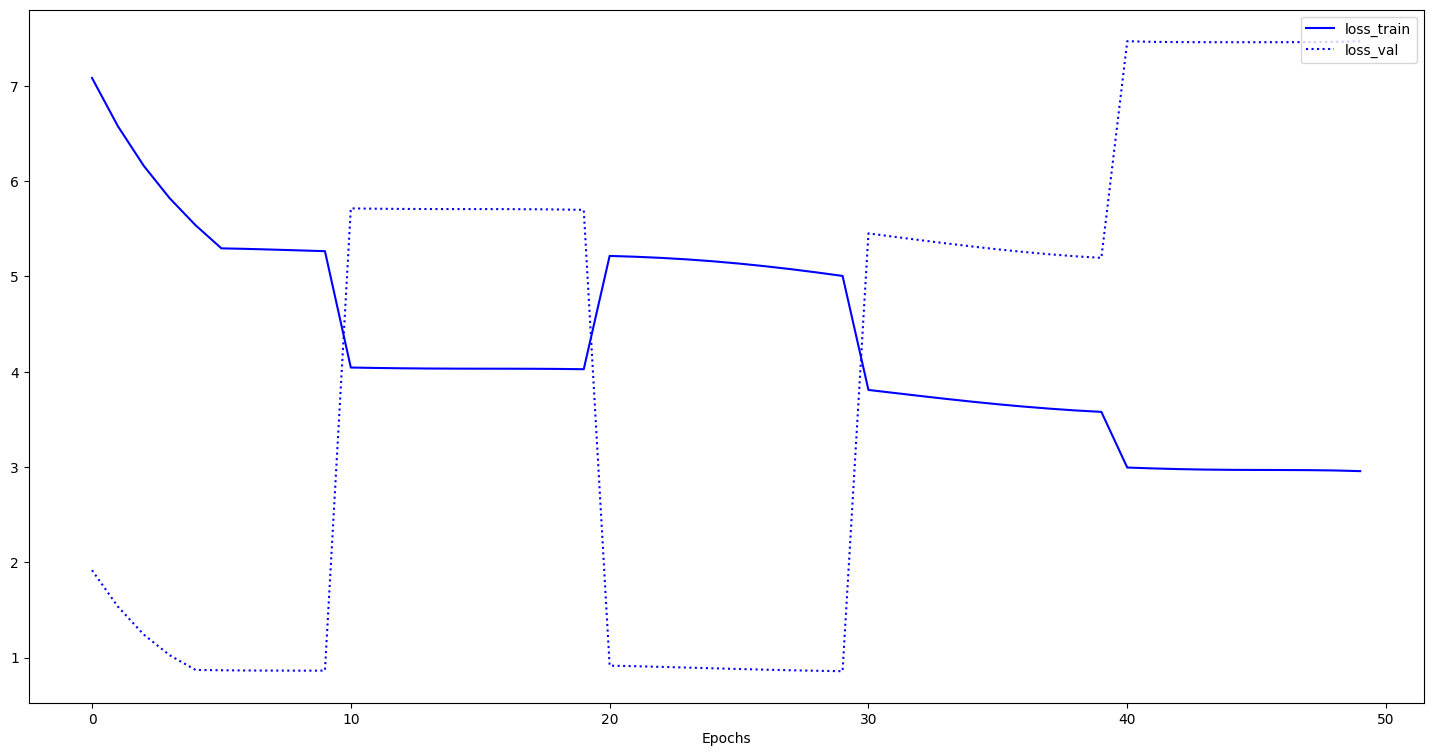

In [10]:
if allow_train:
    helper_functions.plot_loss_curves_post_train(folds_train_results, folds_val_results)

In [11]:
test_results = engine_post_train.test_step(
    model=model,
    dataloader=exp_dataloader,
    loss_fn=loss_fn,
    device=device)

test acc: 0.2
QWK score: 0.030303001403808594
